In [1]:
# SDS Challenge #2 - Used Car Prices
# https://github.com/neurochenyin/sds_challenges/blob/master/challenge_2/challenge.ipynb

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.inspection import permutation_importance


In [2]:
X_full = pd.read_csv(r'D:\Python_ML_case_data\sds_challenges-master\challenge_2\data\public_cars.csv')
X_test_full = pd.read_csv(r'D:\Python_ML_case_data\sds_challenges-master\challenge_2\data\pred_cars.csv')


In [33]:
# X_full.describe()
# X_full.info()
# X_full.head()
# X_full.isnull().sum()
# X_full['price_usd'].value_counts()
X_full.nunique()
# sns.countplot('price_usd',data=X_full)

manufacturer_name      55
model_name           1070
transmission            2
color                  12
odometer_value       5086
year_produced          62
engine_fuel             6
engine_has_gas          2
engine_type             3
engine_capacity        59
body_type              12
has_warranty            2
state                   3
drivetrain              3
feature_0               2
feature_1               2
feature_2               2
feature_3               2
feature_4               2
feature_5               2
feature_6               2
feature_7               2
feature_8               2
feature_9               2
duration_listed       733
dtype: int64

In [3]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['price_usd'], inplace=True)
y = X_full.price_usd
X_full.drop(['price_usd'], axis=1, inplace=True)



In [4]:
from sklearn.preprocessing import MinMaxScaler

In [81]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# categorical_cols = [cname for cname in X_train_full.columns if
#                     X_train_full[cname].nunique() < 10 and 
#                     X_train_full[cname].dtype == "object"]

categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 60 and                     
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()



# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])


# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor #for the model
from tqdm import tqdm,trange

100%|███████████████████████████████████████████| 5/5 [11:35<00:00, 139.17s/it]


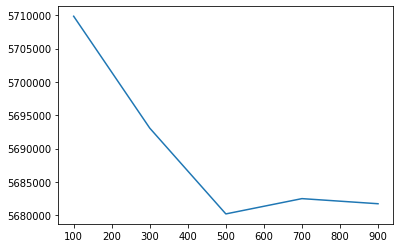

In [35]:
# use cross-validation to select parameters for a machine learning model.
# Step 1: Write a useful function
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """

    my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))])    
    
    scores = -1 * cross_val_score(my_pipeline, X_full, y,cv=3,
                              scoring='neg_mean_squared_error')

    return scores.mean()

# Step 2: Test different parameter values
results = {}
# for each in range(50,450,50):
# for each in range(100,1000,200): #
for each in trange(100,1000,200): #

    results[each] = get_score(each)
    
# Step 3: Find the best parameter value
plt.plot(list(results.keys()), list(results.values()))
plt.show()

n_estimators_best = min(results, key=results.get)

In [41]:
n_estimators_best = 500

In [76]:
# 1. RandomForestRegressor in pipeline
# Define the Model using n_estimators_best
model = RandomForestRegressor(n_estimators=n_estimators_best, random_state=0)


# Create and Evaluate the Pipeline
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
my_pipeline.fit(X_train, y_train)

# get predicted prices on validation data
val_predictions = my_pipeline.predict(X_valid)
print(mean_squared_error(y_valid, val_predictions))

3604622.670585657


In [72]:
# 2. RandomForestRegressor with RandomizedSearchCV

random_search = {#'criterion': ['entropy', 'gini'], # cyin: KeyError: 'gini'
               'max_depth': [2,4,6],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [100, 300, 500]}

# Define model
regr = RandomForestRegressor()

# Data preprocessing pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_valid = my_pipeline.transform(X_valid)



rs_model = RandomizedSearchCV(estimator = regr, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 0, n_jobs = -1)
rs_model.fit(X_train,y_train)

# get predicted prices on validation data
# rs_val_predictions = rs_model.predict(X_valid)
# print(mean_squared_error(y_valid, rs_val_predictions))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.1min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [73]:
# get predicted prices on validation data
rs_val_predictions = rs_model.predict(X_valid)
print(mean_squared_error(y_valid, rs_val_predictions))

6102838.223803951


In [19]:
from xgboost import XGBRegressor
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV

In [78]:
# 3. Xgboost in pipeline
# Define the Model using n_estimators_best
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05) # Typical values range from 100-1000


# Create and Evaluate the Pipeline
# Bundle preprocessing and modeling code in a pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])


# Fit model
# xgb_pipeline.fit(X_train, y_train)
#  cyin: xgboost using pipeline: 
#     1. to seperate model and pipeline(used only for preprocessing) 
#     or
#     2. to set param in pipeline: estimator + __(2 underscore) + normal param names 
# https://stackoverflow.com/questions/58136107/xgbregressor-using-pipeline
#https://www.kaggle.com/questions-and-answers/101994

# Make a copy to avoid changing original data
X_valid_eval=X_valid.copy()
# Remove the model from pipeline
eval_set_pipe = Pipeline(steps = [('preprocessor', preprocessor)])
# fit transform X_valid.copy()
X_valid_eval = eval_set_pipe.fit(X_train, y_train).transform (X_valid_eval)

xgb_pipeline.fit(X_train, y_train, model__early_stopping_rounds=5, model__eval_metric = "mae", 
                 model__eval_set=[(X_valid_eval, y_valid)],model__verbose=False)

# get predicted prices on validation data
xgb_val_predictions = xgb_pipeline.predict(X_valid)
print(mean_squared_error(y_valid, xgb_val_predictions))

2940997.754179973


In [80]:
# 3. still Xgboost in pipeline but just using default param
xgb_pipeline_raw = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)
                             ])

xgb_pipeline_raw.fit(X_train, y_train)

# get predicted prices on validation data
xgb_val_predictions = xgb_pipeline_raw.predict(X_valid)
print(mean_squared_error(y_valid, xgb_val_predictions))

2940997.754179973


In [82]:
# 4. Xgboost with RandomizedSearchCV

# http://danielhnyk.cz/how-to-use-xgboost-in-python/
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
#     "n_estimators": st.randint(3, 40),
    "n_estimators": range(100,1000,200),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

# xgbreg = XGBRegressor(nthreads=-1)  
# xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('model', xgbreg)
#                              ])

# gs = RandomizedSearchCV(xgb_pipeline, params, n_jobs=1)
# gs.fit(X_train, y_train,early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False) # cyin: has error
# gs.best_model_

#  cyin: xgboost using RandomizedSearchCV needs to seperate with pipeline otherwise error: 
#     use pipeline only for preprocessing 

# Define model
xgbreg = XGBRegressor(n_estimators=500, learning_rate=0.05)

# Data preprocessing pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_valid = my_pipeline.transform(X_valid)


rs_model = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
rs_model.fit(X_train, y_train)  
# rs_model.best_estimator_


# get predicted prices on validation data
rs_val_predictions = rs_model.predict(X_valid)
print(mean_squared_error(y_valid, rs_val_predictions))


3132839.197929708


In [ ]:
# did after comparision of 4 ways:
xgb_test_predictions= xgb_pipeline_raw.predict(X_test)

In [95]:
pred_data = np.round(xgb_test_predictions,-2)

In [94]:
np.round(1115.555,-2)

1100.0

In [96]:
df = pd.DataFrame(data=pred_data)
df.head()

,0
0,2000.0
1,1800.0
2,4700.0
3,11200.0
4,5000.0


In [97]:
df.to_csv(r'D:\Python_ML_case_data\sds_challenges-master\challenge_2\data\challenge_2_preded_Chen.csv',index=False, header=False)